In [1]:
import numpy as np
import pandas as pd 
import os, copy
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
import matplotlib.image as image
%matplotlib inline

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

## 1. Initial processing of data

In [2]:
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
65527,00016184_000.png,No Finding,0,16184,42,F,PA,2662,2665,0.143,0.143,NaN
1473,00000382_001.png,No Finding,1,382,71,F,PA,2710,2991,0.143,0.143,NaN
98,00000022_000.png,No Finding,0,22,48,M,PA,2048,2500,0.171,0.171,NaN


In [3]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [4]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
5467,00029779_000.png,No Finding,0,29779,083Y,F,PA,1766,1807,0.194311,0.194311
671,00003466_000.png,No Finding,0,3466,042Y,F,PA,2048,2500,0.168000,0.168000
1696,00008841_028.png,Atelectasis|Emphysema,28,8841,049Y,F,AP,2500,2048,0.168000,0.168000


In [5]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5606 non-null   object 
 1   Finding Labels               5606 non-null   object 
 2   Follow-up #                  5606 non-null   int64  
 3   Patient ID                   5606 non-null   int64  
 4   Patient Age                  5606 non-null   object 
 5   Patient Gender               5606 non-null   object 
 6   View Position                5606 non-null   object 
 7   OriginalImageWidth           5606 non-null   int64  
 8   OriginalImageHeight          5606 non-null   int64  
 9   OriginalImagePixelSpacing_x  5606 non-null   float64
 10  OriginalImagePixelSpacing_y  5606 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 481.9+ KB


In [6]:
# drop the Unnamed: 11 column from the NIH data
all_xray_df.drop(columns=['Unnamed: 11'], inplace=True)

In [7]:
# Samples of comorbid thoracic pathologies
sample(all_xray_df['Finding Labels'].unique().tolist(),10)

['Atelectasis|Emphysema|Infiltration|Pleural_Thickening|Pneumothorax',
 'Atelectasis|Consolidation|Infiltration|Pneumothorax',
 'Consolidation|Mass|Nodule|Pleural_Thickening',
 'Atelectasis|Fibrosis|Infiltration|Mass',
 'Effusion|Emphysema|Pneumothorax',
 'Infiltration|Mass|Nodule|Pneumonia',
 'Cardiomegaly|Effusion|Mass',
 'Fibrosis|Pneumonia',
 'Consolidation|Effusion|Infiltration|Mass|Pleural_Thickening',
 'Pneumothorax']

In [8]:
# Extract individual pathologies
findings = set()
for f in all_xray_df['Finding Labels'].unique():
    findings.update(f.split('|'))

all_labels = list(findings)
print("Total number of single diagnoses:", len(all_labels))
print(all_labels)

Total number of single diagnoses: 15
['Edema', 'Pneumothorax', 'Effusion', 'No Finding', 'Consolidation', 'Emphysema', 'Nodule', 'Atelectasis', 'Mass', 'Fibrosis', 'Pleural_Thickening', 'Hernia', 'Pneumonia', 'Cardiomegaly', 'Infiltration']


In [9]:
# Apply one-hot encoding on individual diagnosis
for c_label in all_labels:
    all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
all_xray_df['Class'] = all_xray_df['Pneumonia'].apply(lambda x: 'Pneumonia' if x==1 else "Non-pneumonia")
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Nodule,Atelectasis,Mass,Fibrosis,Pleural_Thickening,Hernia,Pneumonia,Cardiomegaly,Infiltration,Class
36377,00009603_000.png,No Finding,0,9603,63,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,Non-pneumonia
90276,00022446_000.png,No Finding,0,22446,37,F,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,Non-pneumonia
82453,00020286_022.png,No Finding,22,20286,65,F,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,0,0,Non-pneumonia


In [10]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Edema                        112120 non-null  int64  
 12  Pneumothorax                 112120 non-null  int64  
 13 

## 2. Demographic data analysis

### Age

In [11]:
all_xray_df['Patient Age'].describe()

count    112120.000000
mean         46.901463
std          16.839923
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         414.000000
Name: Patient Age, dtype: float64

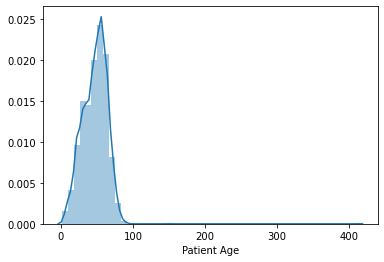

In [12]:
sns.distplot(all_xray_df['Patient Age']);

In [13]:
# Patient with age more than 100
over100 = all_xray_df[all_xray_df['Patient Age'] > 100]
over100

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Nodule,Atelectasis,Mass,Fibrosis,Pleural_Thickening,Hernia,Pneumonia,Cardiomegaly,Infiltration,Class
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,1,0,0,Pneumonia
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,0,0,Non-pneumonia
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,Non-pneumonia
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,...,0,0,0,0,0,0,0,0,0,Non-pneumonia
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,...,0,0,1,0,0,0,0,0,1,Non-pneumonia
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,Non-pneumonia
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,...,0,0,0,0,0,0,0,0,0,Non-pneumonia
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,...,0,0,0,0,0,0,0,0,1,Non-pneumonia
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,0,0,Non-pneumonia
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,...,0,0,1,0,1,0,0,0,0,Non-pneumonia


In [14]:
# Number of patients with age more than 100
print(len(over100))

16


In [15]:
# drop patients with wrong ages
all_xray_df = all_xray_df[all_xray_df['Patient Age'] <= 100]

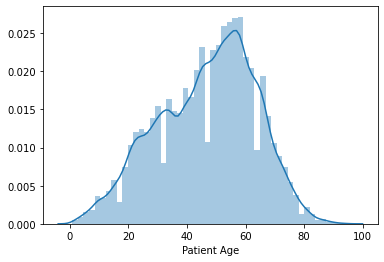

In [16]:
sns.distplot(all_xray_df['Patient Age']);

In [17]:
all_xray_df['Patient Age'].describe()

count    112104.000000
mean         46.872574
std          16.598152
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max          95.000000
Name: Patient Age, dtype: float64

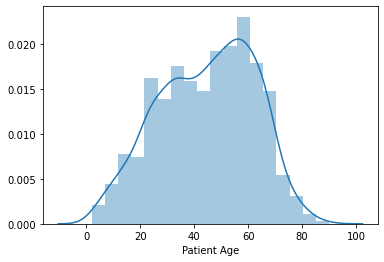

In [18]:
sns.distplot(all_xray_df.loc[all_xray_df.Pneumonia==1]['Patient Age']);

### Gender

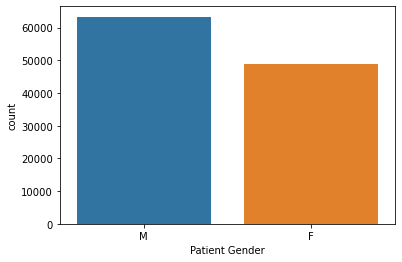

In [19]:
# Gender distribution
sns.countplot(data = all_xray_df, x = 'Patient Gender');

In [20]:
num_male = all_xray_df[all_xray_df['Patient Gender'] == 'M']
num_female = all_xray_df[all_xray_df['Patient Gender'] == 'F']

In [21]:
print(f'Gender distribution for complete population\nMale: {len(num_male)} ({100.0*len(num_male)/len(all_xray_df):.2f}%), \
Female: {len(num_female)} ({100.0*len(num_female)/len(all_xray_df):.2f}%)')

Gender distribution for complete population
Male: 63328 (56.49%), Female: 48776 (43.51%)


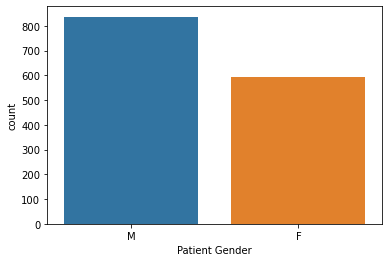

In [22]:
# Gender distribution for Pneumonia patients
sns.countplot(data = all_xray_df.loc[all_xray_df.Pneumonia==1], x = 'Patient Gender');

### View position

In [23]:
all_xray_df['View Position'].unique()

array(['PA', 'AP'], dtype=object)

In [24]:
pos_pa = all_xray_df[all_xray_df['View Position'] == 'PA']
pos_ap = all_xray_df[all_xray_df['View Position'] == 'AP']

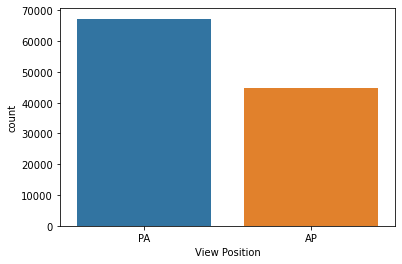

In [25]:
sns.countplot(data = all_xray_df, x = 'View Position');

In [26]:
print(f'View position value distribution\nPA: {len(pos_pa)} ({100.0*len(pos_pa)/len(all_xray_df):.2f}%), AP: {len(pos_ap)} ({100.0*len(pos_ap)/len(all_xray_df):.2f}%)')

View position value distribution
PA: 67299 (60.03%), AP: 44805 (39.97%)


## 3. Pneumonia and comorbid findings

['Pneumonia', 'Pneumothorax', 'Effusion', 'No Finding', 'Consolidation', 'Emphysema', 'Nodule', 'Atelectasis', 'Mass', 'Fibrosis', 'Pleural_Thickening', 'Hernia', 'Edema', 'Cardiomegaly', 'Infiltration']


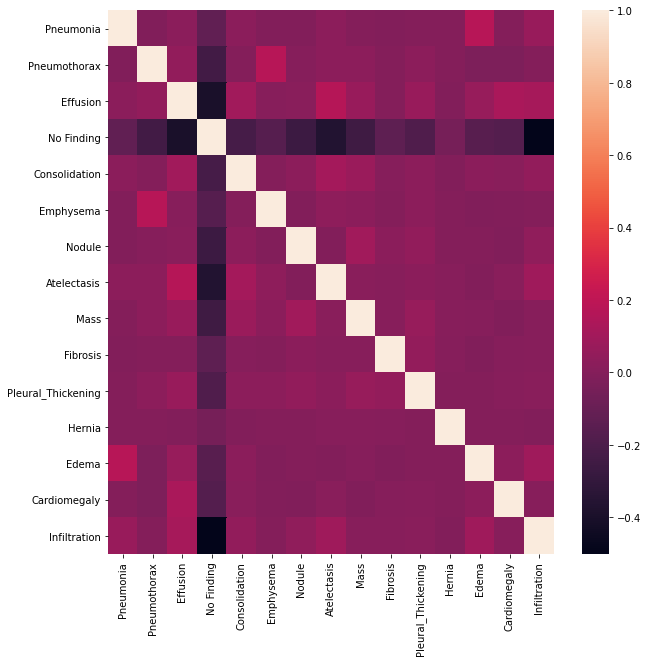

In [27]:
# Distribution of other diseases that are comorbid with pneumonia
idx = all_labels.index('Pneumonia')
all_labels[0], all_labels[idx] = all_labels[idx], all_labels[0]
print(all_labels)

corr_df = all_xray_df[all_labels].corr() 

plt.figure(figsize=(10,10))
sns.heatmap(corr_df);

In [28]:
all_findings = all_xray_df[all_xray_df["No Finding"] == 0]
print(f'{len(all_findings)} cases in which at least one thoracic desease exists out of total {len(all_xray_df)} cases.')

51751 cases in which at least one thoracic desease exists out of total 112104 cases.


In [29]:
pneumonia = all_xray_df.loc[all_xray_df.Pneumonia==1]

print(f'Pneumonia images: {len(pneumonia)} ({100.0*len(pneumonia)/len(all_xray_df) :.2f}% of the complete population)')
print(f'Pneumonia images: {len(pneumonia)} ({100.0*len(pneumonia)/len(all_findings) :.2f}% of population where at least one thoracic condition exists)')

Pneumonia images: 1430 (1.28% of the complete population)
Pneumonia images: 1430 (2.76% of population where at least one thoracic condition exists)


In [30]:
print('Presence (%) of each finding in the entire dataset:')
(all_xray_df[findings].sum()*100/len(all_xray_df)).sort_values(ascending=False)

Presence (%) of each finding in the entire dataset:


No Finding            53.836616
Infiltration          17.743345
Effusion              11.878256
Atelectasis           10.310069
Nodule                 5.647435
Mass                   5.155035
Pneumothorax           4.728645
Consolidation          4.163099
Pleural_Thickening     3.018626
Cardiomegaly           2.476272
Emphysema              2.244345
Edema                  2.053450
Fibrosis               1.503961
Pneumonia              1.275601
Hernia                 0.202491
dtype: float64

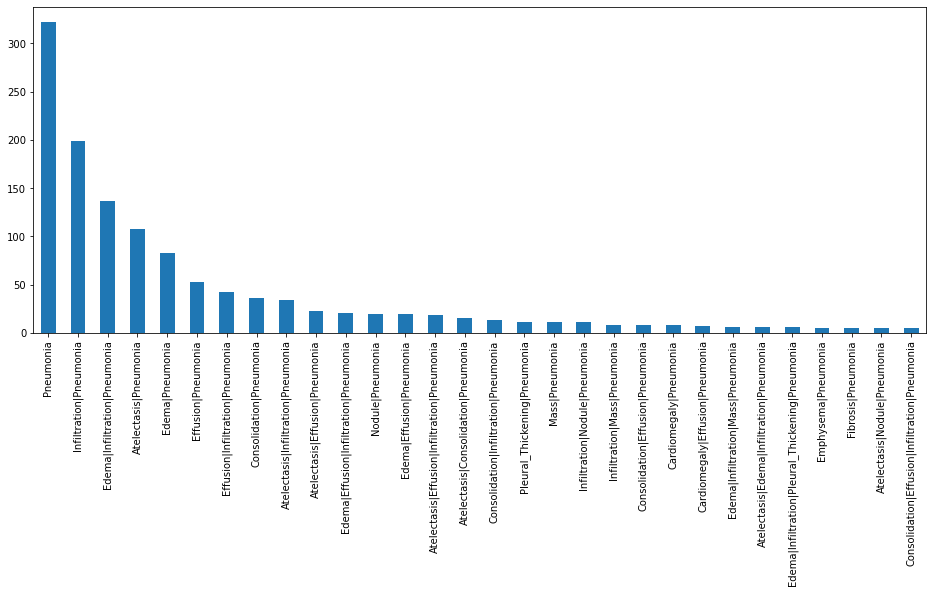

In [31]:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df['Pneumonia']==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

[Text(0, 0.5, 'Number of Images with Label')]

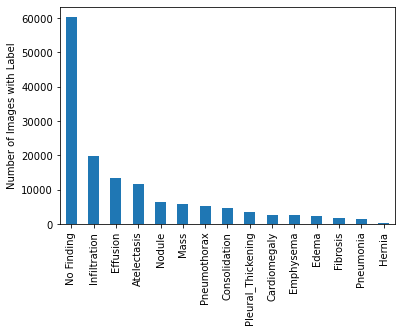

In [32]:
ax = all_xray_df[all_labels].sum().sort_values(ascending=False).plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

In [33]:
print('Distribution of pneumonia cases with other comorbid thoracic conditions (top 25 in descending order):')
all_xray_df[all_xray_df['Pneumonia']==1]['Finding Labels'].value_counts()[0:25]

Distribution of pneumonia cases with other comorbid thoracic conditions (top 25 in descending order):


Pneumonia                                      322
Infiltration|Pneumonia                         199
Edema|Infiltration|Pneumonia                   137
Atelectasis|Pneumonia                          108
Edema|Pneumonia                                 83
Effusion|Pneumonia                              53
Effusion|Infiltration|Pneumonia                 42
Consolidation|Pneumonia                         36
Atelectasis|Infiltration|Pneumonia              34
Atelectasis|Effusion|Pneumonia                  23
Edema|Effusion|Infiltration|Pneumonia           21
Nodule|Pneumonia                                19
Edema|Effusion|Pneumonia                        19
Atelectasis|Effusion|Infiltration|Pneumonia     18
Atelectasis|Consolidation|Pneumonia             15
Consolidation|Infiltration|Pneumonia            13
Pleural_Thickening|Pneumonia                    11
Mass|Pneumonia                                  11
Infiltration|Nodule|Pneumonia                   11
Infiltration|Mass|Pneumonia    

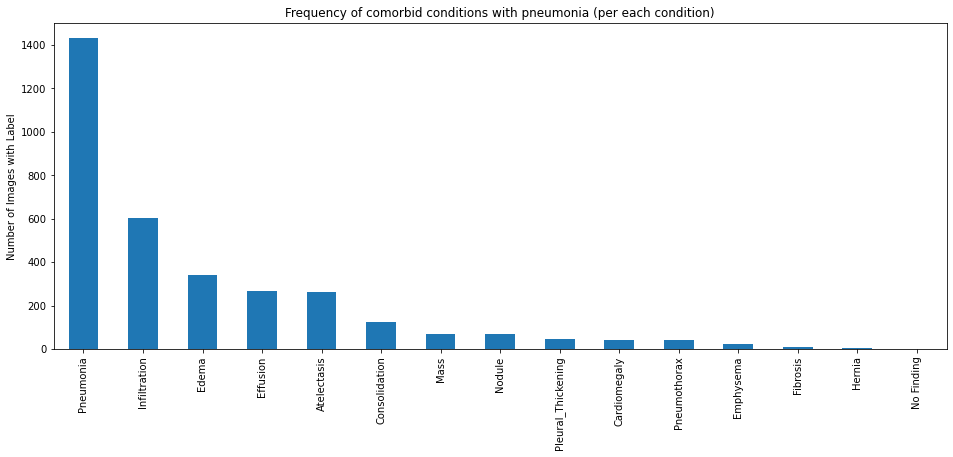

In [34]:
plt.figure(figsize=(16,6))
ax = pneumonia[all_labels].sum().sort_values(ascending=False).plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')
ax.set_title("Frequency of comorbid conditions with pneumonia (per each condition)")
plt.show()

## Records per patient

In [35]:
uniqueID = list(all_xray_df['Patient ID'].unique())
print(f'Total unique patients: {len(uniqueID)}, average number records per patient: {len(all_xray_df)/len(uniqueID) :.2f}')

Total unique patients: 30802, average number records per patient: 3.64


In [36]:
records_per_patient = []

for pid in uniqueID:
    records_per_patient.append(len(all_xray_df[all_xray_df['Patient ID'] == pid]))

In [37]:
# Sample patient with 10 records
sample_idx = records_per_patient.index(10)
# print(sample_idx)
sample_ID = uniqueID[sample_idx]
print('Sample patient ID with 10 records:',sample_ID)
all_xray_df[all_xray_df['Patient ID']==sample_ID]

Sample patient ID with 10 records: 54


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Nodule,Atelectasis,Mass,Fibrosis,Pleural_Thickening,Hernia,Pneumonia,Cardiomegaly,Infiltration,Class
242,00000054_000.png,Infiltration,0,54,71,F,PA,2910,2882,0.143000,...,0,0,0,0,0,0,0,0,1,Non-pneumonia
243,00000054_001.png,No Finding,1,54,72,F,PA,2544,3056,0.139000,...,0,0,0,0,0,0,0,0,0,Non-pneumonia
244,00000054_002.png,No Finding,2,54,74,F,PA,2021,2021,0.194311,...,0,0,0,0,0,0,0,0,0,Non-pneumonia
245,00000054_003.png,No Finding,3,54,63,F,PA,2500,2048,0.168000,...,0,0,0,0,0,0,0,0,0,Non-pneumonia
246,00000054_004.png,No Finding,4,54,64,F,PA,2048,2500,0.168000,...,0,0,0,0,0,0,0,0,0,Non-pneumonia
247,00000054_005.png,No Finding,5,54,64,F,PA,2826,2991,0.143000,...,0,0,0,0,0,0,0,0,0,Non-pneumonia
248,00000054_006.png,Infiltration,6,54,65,F,PA,2992,2991,0.143000,...,0,0,0,0,0,0,0,0,1,Non-pneumonia
249,00000054_007.png,No Finding,7,54,67,F,PA,2992,2991,0.143000,...,0,0,0,0,0,0,0,0,0,Non-pneumonia
250,00000054_008.png,No Finding,8,54,69,F,PA,2500,2048,0.168000,...,0,0,0,0,0,0,0,0,0,Non-pneumonia
251,00000054_009.png,No Finding,9,54,69,F,PA,2798,2991,0.143000,...,0,0,0,0,0,0,0,0,0,Non-pneumonia


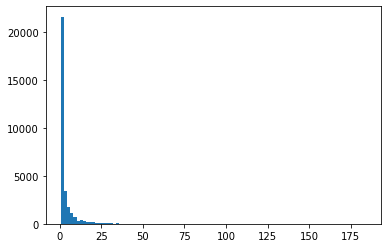

In [38]:
plt.hist(records_per_patient, bins=100)
plt.show()

In [39]:
for i in range(1,11):
    print(f'Number of patients with {i} records in the dataset: {records_per_patient.count(i)} ({100.0*records_per_patient.count(i)/len(uniqueID) :.1f}%)')

Number of patients with 1 records in the dataset: 17501 (56.8%)
Number of patients with 2 records in the dataset: 4112 (13.3%)
Number of patients with 3 records in the dataset: 2101 (6.8%)
Number of patients with 4 records in the dataset: 1330 (4.3%)
Number of patients with 5 records in the dataset: 938 (3.0%)
Number of patients with 6 records in the dataset: 786 (2.6%)
Number of patients with 7 records in the dataset: 610 (2.0%)
Number of patients with 8 records in the dataset: 492 (1.6%)
Number of patients with 9 records in the dataset: 387 (1.3%)
Number of patients with 10 records in the dataset: 320 (1.0%)


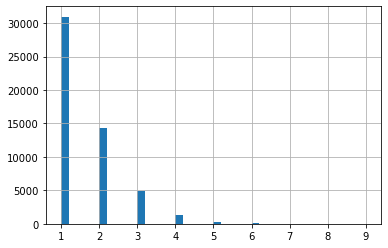

In [40]:
# Full dataset
all_findings[findings].sum(axis=1).hist(bins=40)

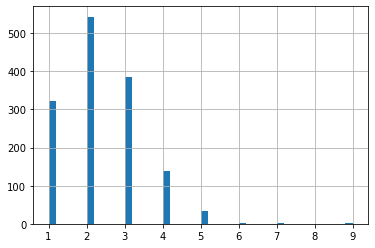

In [41]:
pneumonia[findings].sum(axis=1).hist(bins=40)

In [42]:
pneumonia_unique_patients_num = pneumonia['Patient ID'].nunique()
print(f'Total pneumonia patients: {pneumonia_unique_patients_num}, average number records per pneumonia patient: {len(pneumonia)/pneumonia_unique_patients_num :.2f}')

Total pneumonia patients: 1008, average number records per pneumonia patient: 1.42


## Pixel wise analysis

In [43]:
desc = all_xray_df.iloc[:, 7:11].describe()
desc

,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
count,112104.000000,112104.000000,112104.000000,112104.000000
mean,2646.035253,2486.393153,0.155651,0.155651
std,341.243771,401.270806,0.016174,0.016174
min,1143.000000,966.000000,0.115000,0.115000
25%,2500.000000,2048.000000,0.143000,0.143000
50%,2518.000000,2544.000000,0.143000,0.143000
75%,2992.000000,2991.000000,0.168000,0.168000
max,3827.000000,4715.000000,0.198800,0.198800


In [44]:
def show_min_max_values(col, name):
    print(f'{name} range: [{desc[col]["min"]}, {desc[col]["max"]}]')

In [45]:
show_min_max_values('OriginalImage[Width', 'Image Width')
show_min_max_values('Height]', 'Image Height')

Image Width range: [1143.0, 3827.0]
Image Height range: [966.0, 4715.0]


In [46]:
show_min_max_values('OriginalImagePixelSpacing[x', 'Pixel Spacing over X')
show_min_max_values('y]', 'Pixel Spacing over Y')

Pixel Spacing over X range: [0.115, 0.1988]
Pixel Spacing over Y range: [0.115, 0.1988]


In [47]:
for finding in findings:
    sample_df[finding] = sample_df['Finding Labels'].map(lambda x: 1.0 if finding in x else 0)

In [48]:
def get_image_path(row):
    fpath = None
    f = row['Image Index']
    for d in range(12):
        dname = 'images_' + str(d+1).zfill(3)
        fname = '/data/' + dname + '/images/' + f
        if os.path.isfile(fname):
            fpath = fname
            break
    return fpath

sample_df['image_path'] = sample_df.apply(get_image_path, axis=1)

In [49]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5606 non-null   object 
 1   Finding Labels               5606 non-null   object 
 2   Follow-up #                  5606 non-null   int64  
 3   Patient ID                   5606 non-null   int64  
 4   Patient Age                  5606 non-null   object 
 5   Patient Gender               5606 non-null   object 
 6   View Position                5606 non-null   object 
 7   OriginalImageWidth           5606 non-null   int64  
 8   OriginalImageHeight          5606 non-null   int64  
 9   OriginalImagePixelSpacing_x  5606 non-null   float64
 10  OriginalImagePixelSpacing_y  5606 non-null   float64
 11  Edema                        5606 non-null   float64
 12  Pneumothorax                 5606 non-null   float64
 13  Effusion          

In [50]:
pneumo_samples = sample_df[sample_df['Pneumonia'] == 1]
print("Total pneumonia records in sample dataset:", len(pneumo_samples))

Total pneumonia records in sample dataset: 62


In [51]:
def show_image_distr(img_data, title):
    f = plt.figure()
    f.set_figwidth(10)

    s1 = f.add_subplot(1, 2, 1)
    s1.set_title(title)
    plt.imshow(img_data, cmap='gray')
    
    s2 = f.add_subplot(1, 2, 2)
    s2.set_title('Intensity Distribution')
    plt.hist(img_data[img_data > 0.1].ravel(), bins = 256)

    plt.show()

In [52]:
def pneumo_examples(**vargs):
    idx = []
    num_samples = vargs['num_samples']
    sample_rows = [row for row in range(len(pneumo_samples)) 
                  if pneumo_samples.iloc[row][all_labels].sum() == 1]
    idx = list(pneumo_samples.iloc[sample_rows].index.values)
    print("Number of pneumonia only samples: ", len(idx))
    return sample(idx,num_samples)

def comorbid_examples(labels):
    idx = []
    for label in labels:
        samples = pneumo_samples[pneumo_samples[label] == 1]
        sample_rows = [row for row in range(len(samples)) 
                      if samples.iloc[row][all_labels].sum() == 2]
        sample_idx = list(samples.iloc[sample_rows].index.values)
        idx.append(sample_idx[0]) if sample_idx else False
    return idx

In [53]:
def show_examples(example_idx):
    for idx in example_idx:
        example_data = image.imread(sample_df.iloc[idx]['image_path'])
        print('Image index: ',sample_df.iloc[idx]['Image Index'])
        show_image_distr(example_data, sample_df.iloc[idx]['Finding Labels'])

Number of pneumonia only samples:  14
Sample indices:  [2422, 2522, 2534]

Image index:  00012158_025.png


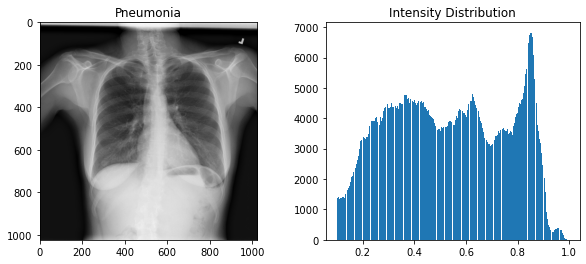

Image index:  00012667_000.png


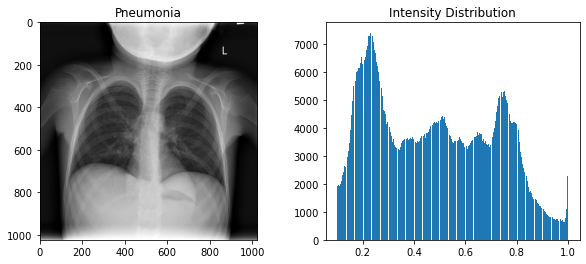

Image index:  00012733_000.png


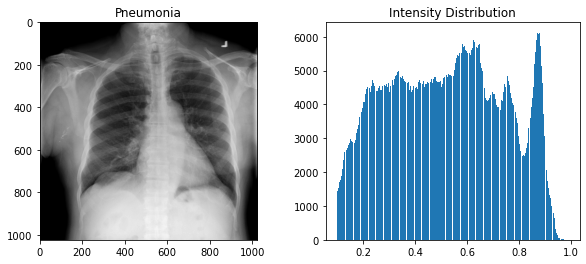

In [54]:
pneumo_idx = pneumo_examples(num_samples=3)
print('Sample indices: ', pneumo_idx)
print()
show_examples(pneumo_idx)

Image index:  00004075_000.png


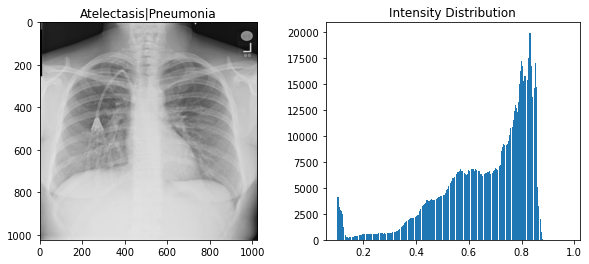

Image index:  00007007_016.png


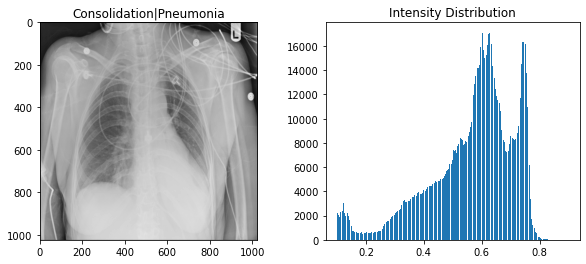

Image index:  00014004_012.png


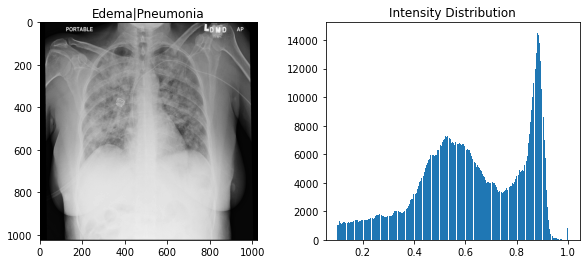

Image index:  00010552_005.png


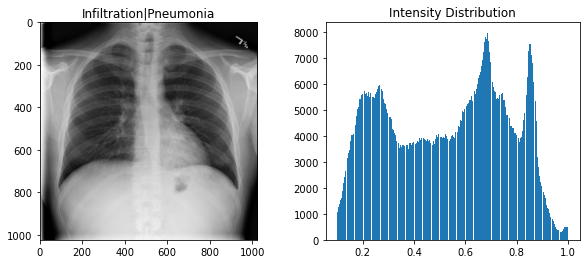

In [55]:
comorbid = ['Atelectasis', 'Consolidation', 'Edema', 'Infiltration']
example_idx = comorbid_examples(comorbid)
show_examples(example_idx)

In [56]:
def get_image_data(row):
    fpath = row['image_path']
    if fpath is not None:
        img = image.imread(fpath)
        return img
    else:
        return None

In [57]:
pneumo_samples1 = copy.copy(pneumo_samples)
pneumo_samples1['image_data'] = np.zeros(len(pneumo_samples))
pneumo_samples1['image_data'] = pneumo_samples.apply(get_image_data, axis=1)
pneumo_samples1.head(2)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Atelectasis,Mass,Fibrosis,Pleural_Thickening,Hernia,Pneumonia,Cardiomegaly,Infiltration,image_path,image_data
256,00001373_010.png,Cardiomegaly|Effusion|Pneumonia,10,1373,058Y,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,/data/images_002/images/00001373_010.png,"[[0.0, 0.003921569, 0.007843138, 0.007843138, ..."
287,00001529_004.png,Consolidation|Infiltration|Pneumonia,4,1529,054Y,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,/data/images_002/images/00001529_004.png,"[[0.91764706, 0.89411765, 0.8509804, 0.7960784..."


In [58]:
pneumo_data = pneumo_samples1[pneumo_samples1['image_data'].notna()]['image_data'].to_numpy()
len(pneumo_data)

62

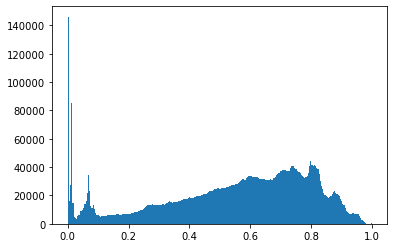

In [59]:
pneumo_intensities = []
for data in pneumo_data[:5]:
    pneumo_intensities.extend(data.flatten().tolist())
plt.hist(pneumo_intensities,bins=256)
plt.show()

In [60]:
def show_image_mask(img_data, th1, th2):
    f = plt.figure()
    f.set_figwidth(15)

    s1 = f.add_subplot(1, 3, 1)
    s1.set_title('Image')
    plt.imshow(img_data, cmap='gray')

    mask = (img_data > th1) & (img_data < th2)

    s2 = f.add_subplot(1, 3, 2)
    s2.set_title('Mask')
    plt.imshow(mask.astype(int)*255, cmap='gray')
    
    s3 = f.add_subplot(1, 3, 3)
    s3.set_title('Intensity Distribution')
#     sns.distplot(img_data);
    plt.hist(img_data[mask], bins = 256)

    plt.show()

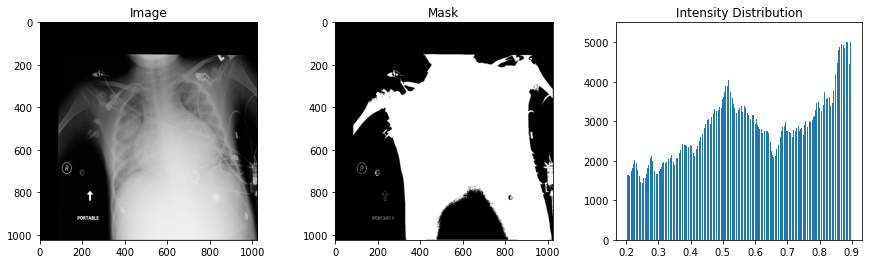

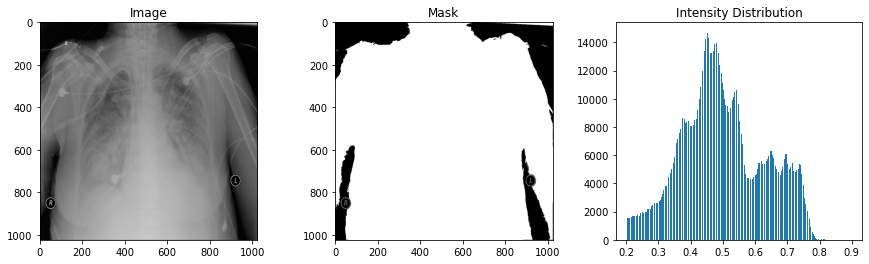

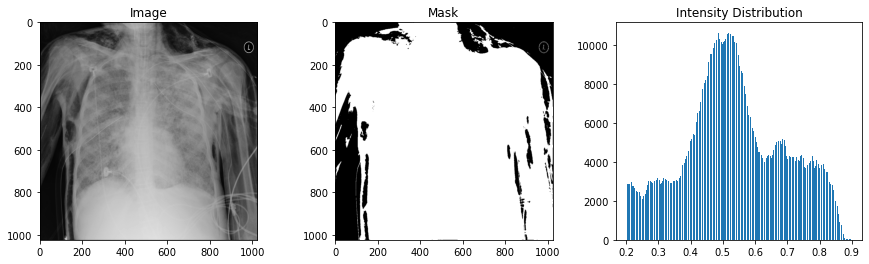

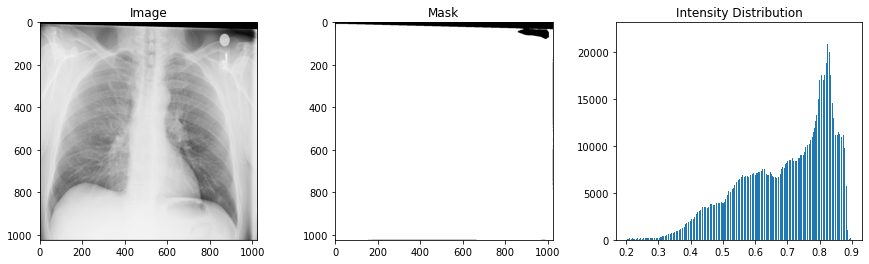

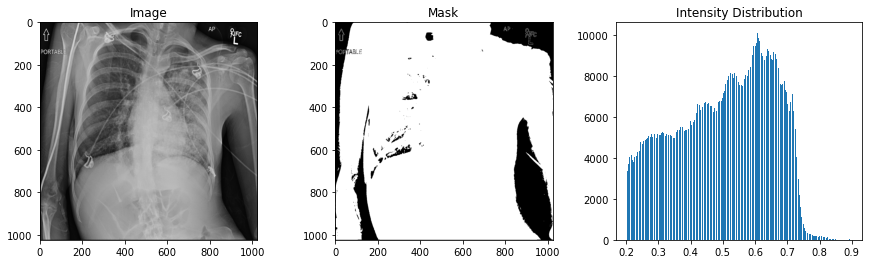

In [61]:
background_threshold = 0.2
foreground_threshold = 0.9

for data in sample(list(pneumo_data), 5):
    show_image_mask(data, background_threshold, foreground_threshold)

In [62]:
max_samples = 1000
def get_intensities(label):
    intensities = []
    paths = sample_df[sample_df[label]==1].head(max_samples)['image_path'].values
#     paths = sample_df[sample_df[label]==1]['image_path'].values
    print(f'Label: {label}, number of samples for intensity: {len(paths)}')
    for path in paths:
        data = image.imread(path)
        mask = (data > background_threshold) & (data < foreground_threshold)
        intensities.extend(data[mask].flatten().tolist())
        return intensities

Label: Edema, number of samples for intensity: 118
Label: Pneumothorax, number of samples for intensity: 271
Label: Effusion, number of samples for intensity: 644
Label: No Finding, number of samples for intensity: 1000
Label: Consolidation, number of samples for intensity: 226
Label: Emphysema, number of samples for intensity: 127
Label: Nodule, number of samples for intensity: 313
Label: Atelectasis, number of samples for intensity: 508
Label: Mass, number of samples for intensity: 284
Label: Fibrosis, number of samples for intensity: 84
Label: Pleural_Thickening, number of samples for intensity: 176
Label: Hernia, number of samples for intensity: 13
Label: Pneumonia, number of samples for intensity: 62
Label: Cardiomegaly, number of samples for intensity: 141
Label: Infiltration, number of samples for intensity: 967


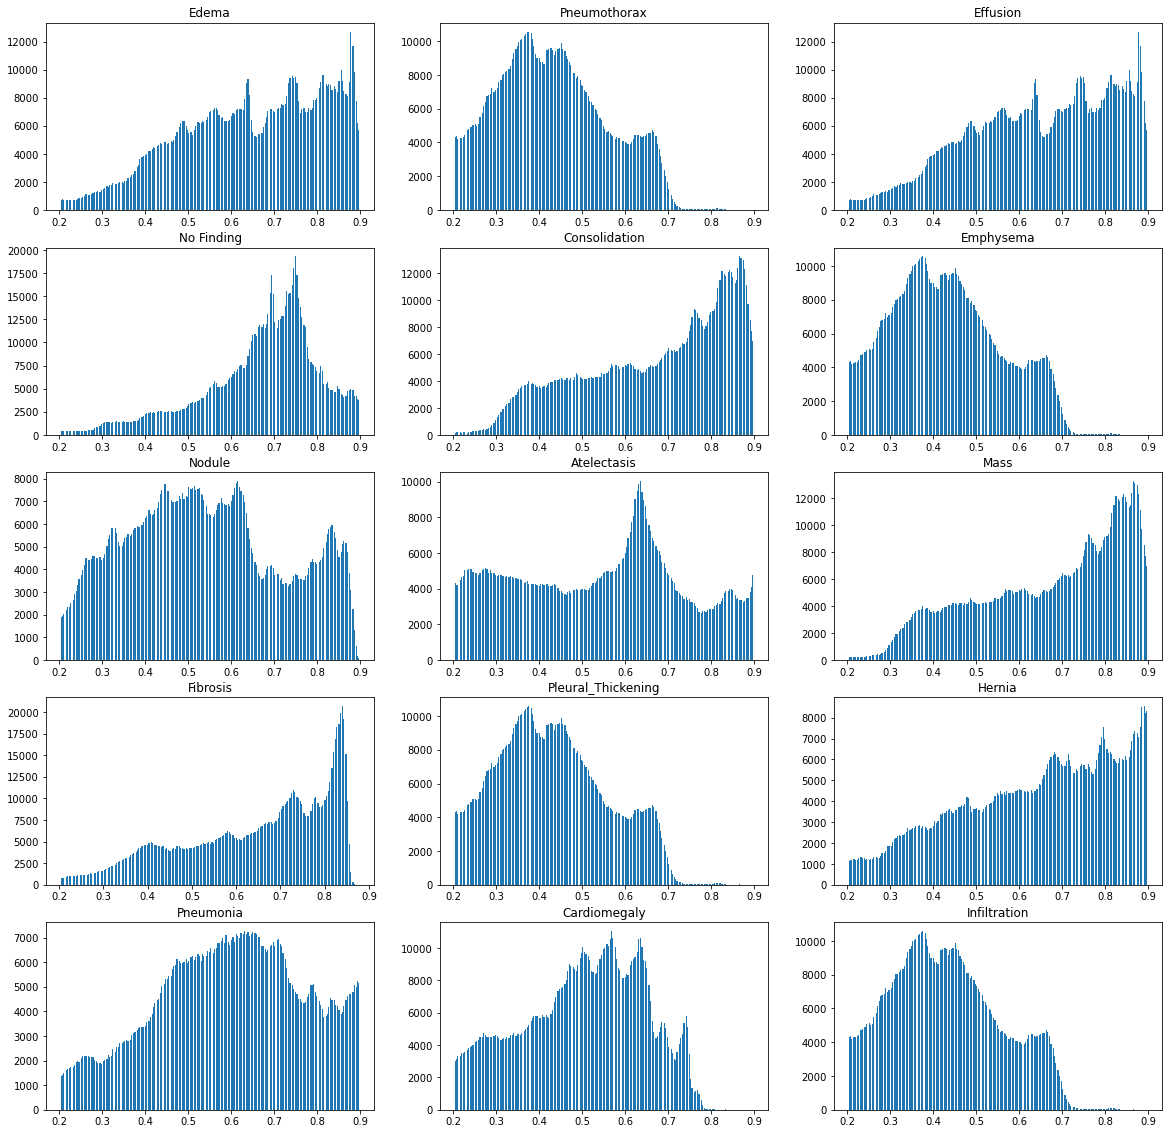

In [63]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

for i,finding in enumerate(findings):
    intensities = get_intensities(finding)

    s = f.add_subplot(5, len(findings)/5, i+1)
    s.set_title(finding)
    plt.hist(intensities, bins = 256)
    
plt.show()

#### Similar Distribution Group 1: Emphysema, Pleural Thickening, Pneumothorax, Infitration:

Label: Emphysema, number of samples for intensity: 127
Label: Pleural_Thickening, number of samples for intensity: 176
Label: Pneumothorax, number of samples for intensity: 271
Label: Infiltration, number of samples for intensity: 967


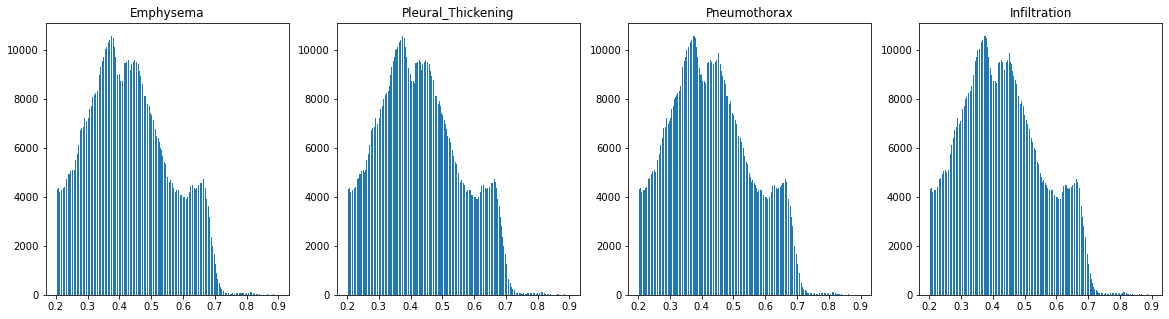

In [64]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)

for i,finding in enumerate([ 'Emphysema', 'Pleural_Thickening', 'Pneumothorax', 'Infiltration']):
    intensities = get_intensities(finding)

    s = f.add_subplot(1, 4, i+1)
    s.set_title(finding)
    plt.hist(intensities, bins = 256)
    
plt.show()

#### Similar Distribution Group 2: Consolidation, Edema, Effusion, Hernia:

Label: Consolidation, number of samples for intensity: 226
Label: Edema, number of samples for intensity: 118
Label: Effusion, number of samples for intensity: 644
Label: Hernia, number of samples for intensity: 13


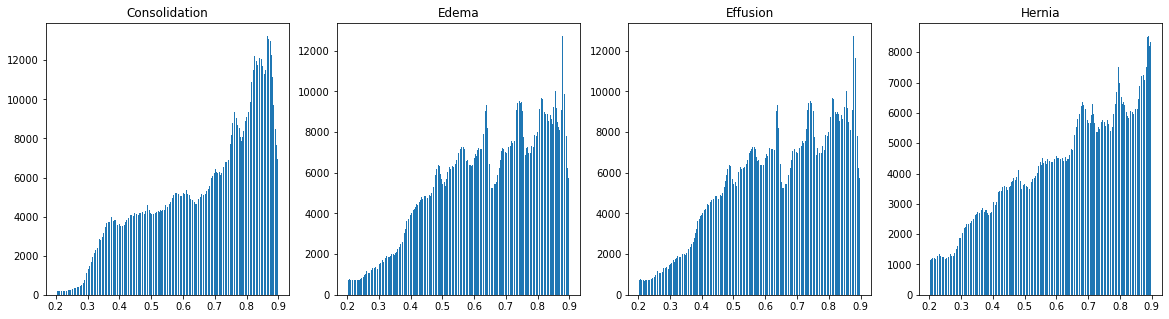

In [65]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)

for i,finding in enumerate([ 'Consolidation', 'Edema', 'Effusion', 'Hernia']):
    intensities = get_intensities(finding)

    s = f.add_subplot(1, 4, i+1)
    s.set_title(finding)
    plt.hist(intensities, bins = 256)
    
plt.show()

#### Similar Distribution Group 3: Pneumonia, Nodule, Cardiomegaly:

Label: Pneumonia, number of samples for intensity: 62
Label: Nodule, number of samples for intensity: 313
Label: Cardiomegaly, number of samples for intensity: 141


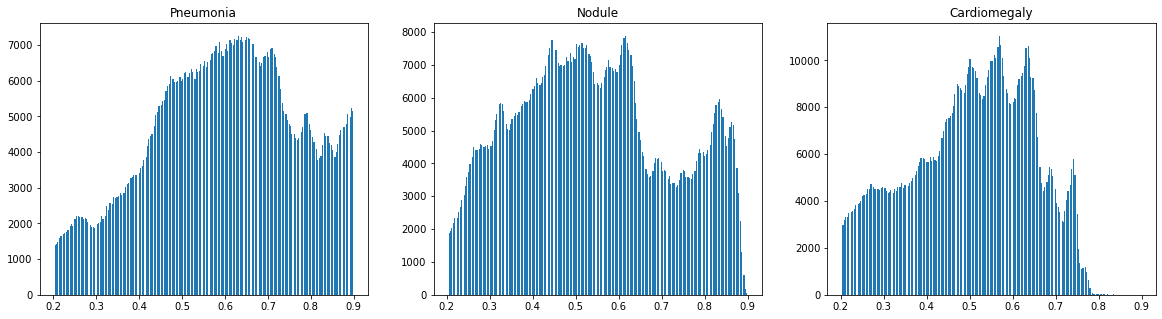

In [66]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)

for i,finding in enumerate([ 'Pneumonia', 'Nodule', 'Cardiomegaly']):
    intensities = get_intensities(finding)

    s = f.add_subplot(1, 3, i+1)
    s.set_title(finding)
    plt.hist(intensities, bins = 256)
    
plt.show()

### Conclusion
- Background (almost black) and foreground (almost white) should be removed by applying proper threholding.
- The intensity distribution for Pneumonia generally tends to exhibit a peak in the range between 0.55 and 0.75 (in the normalized distribution), however, the presence of other comorbid conditions can alter the intensity distribution pattern. 
- The consistency of the intensity distribution can be significantly affected by the presence of external entities and improper image capturing.